# Libraries

In [4]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from tqdm import tqdm



# Loading the Files

Download the csv files into the `data/` directory.

In [175]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)


print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [60]:
print(trainingSet['Score'].value_counts())

Score
5.0    793163
4.0    335228
3.0    176082
1.0     91190
2.0     89678
Name: count, dtype: int64


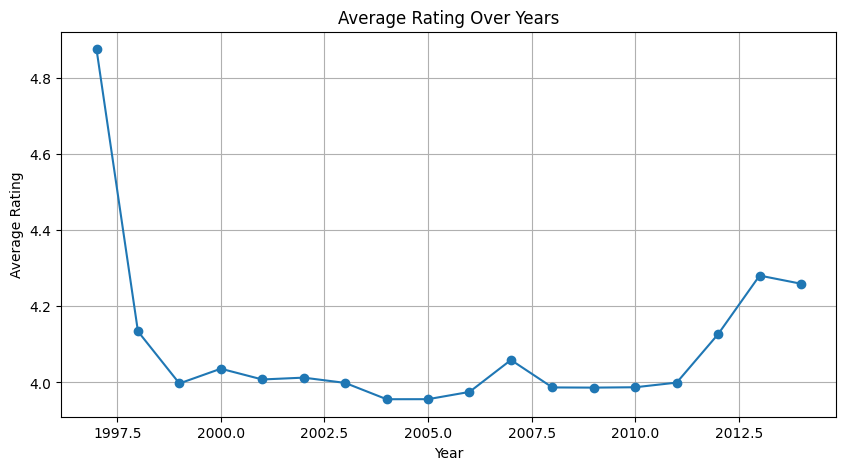

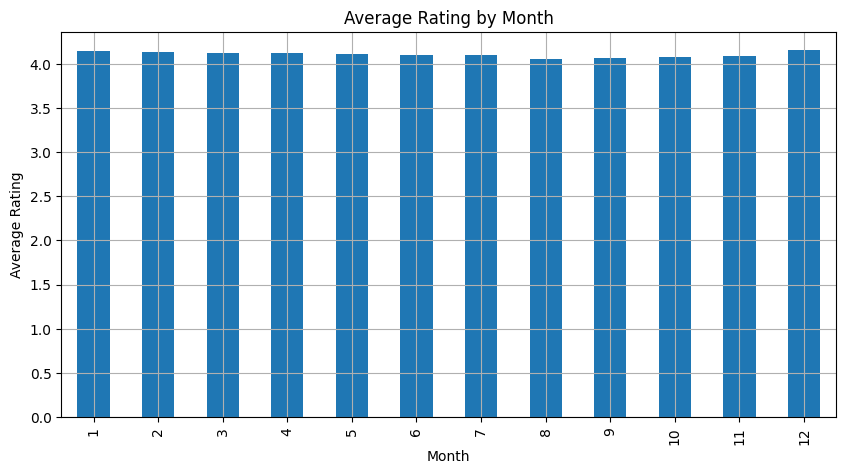

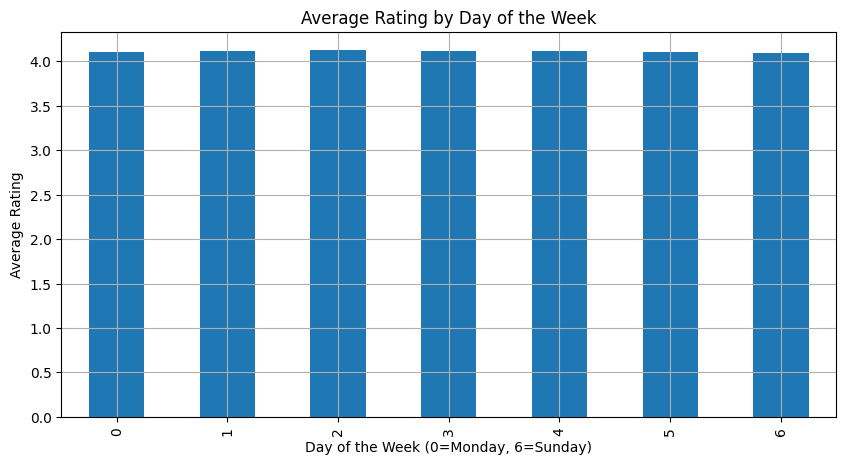

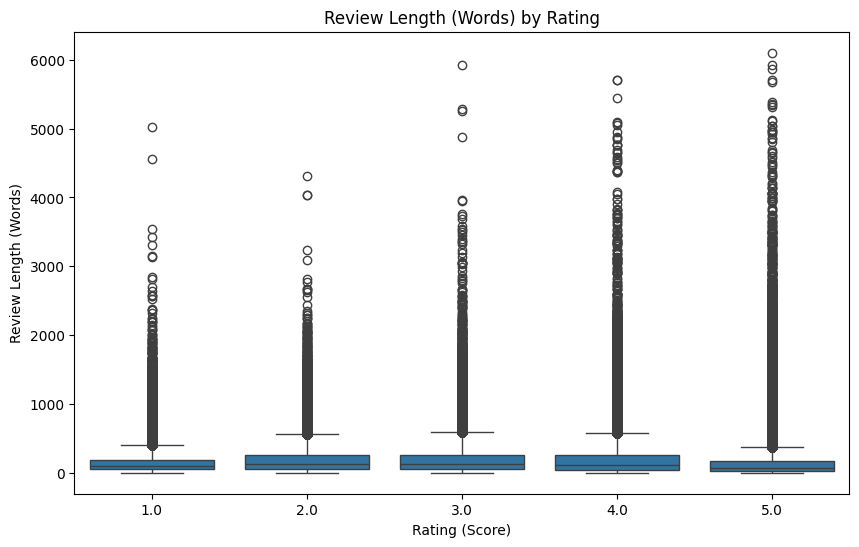

Correlation between Year and Score: 0.08630055248436261


In [82]:
value_count = trainingSet['Score'].value_counts()

trainingSet['Time'] = pd.to_datetime(trainingSet['Time'], unit='s')
trainingSet['Year'] = trainingSet['Time'].dt.year
trainingSet['Month'] = trainingSet['Time'].dt.month
trainingSet['Day'] = trainingSet['Time'].dt.day_of_week

avg_rating_per_year = trainingSet.groupby('Year')['Score'].mean()
avg_rating_per_month = trainingSet.groupby('Month')['Score'].mean()
avg_rating_per_day = trainingSet.groupby('Day')['Score'].mean()

# Plot the average rating over years
plt.figure(figsize=(10, 5))
avg_rating_per_year.plot(kind='line', marker='o')
plt.title('Average Rating Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
avg_rating_per_month.plot(kind='bar')
plt.title('Average Rating by Month')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
avg_rating_per_day.plot(kind='bar')
plt.title('Average Rating by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

trainingSet['Text'] = trainingSet['Text'].fillna('')
trainingSet['Review_Length_Words'] = trainingSet['Text'].apply(lambda x: len(x.split()))



plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='Review_Length_Words', data=trainingSet)
plt.title('Review Length (Words) by Rating')
plt.xlabel('Rating (Score)')
plt.ylabel('Review Length (Words)')
plt.show()
        

# Calculate the correlation between Year and Score
correlation = trainingSet[['Year', 'Score']].corr().iloc[0, 1]
print(f"Correlation between Year and Score: {correlation}")

    

Number of outliers (Review Length Words) for each rating:
{1.0: 6855, 2.0: 0, 3.0: 0, 4.0: 0, 5.0: 69455}

Number of outliers (Review Length Chars) for each rating:
{1.0: 6923, 2.0: 5543, 3.0: 10131, 4.0: 19922, 5.0: 71616}


# Adding Features

In [176]:
#Analysis for sentiment text analysis

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
"""
lexicon (Is the dictionary with the polarity mapping)
"""
tqdm.pandas()

def review_length(df): 
    df['Review_Length_Words'] = df['Text'].progress_apply(lambda x: len(x.split()))



def textScore(df):
    analyzer = SentimentIntensityAnalyzer()
    df['text_sentiment_score'] = df['Text'].progress_apply(lambda x: analyzer.polarity_scores(str(x))['compound']) #Takes much longer which make sense 
    df['summary_sentiment_score'] = df['Summary'].progress_apply(lambda x: analyzer.polarity_scores(str(x))['compound']) #Takes much shorter time
    



In [177]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    print("Filling N/a values with empty strings")
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')

    print("Feature engineering the helpfulness")
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Calculate length in terms of number of words
    print("Featuring sentiment scores")
    textScore(df) #Adding sentiment_scores for text (Both for summary and text)

    print("Featuring lenght scores")
    review_length(df) #Adding lenght features to the dataframw
    

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train_sample = trainingSet.sample(frac=0.1, random_state=42)
    train = add_features_to(train_sample)
    print(train.columns)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Filling N/a values with empty strings
Feature engineering the helpfulness
Featuring sentiment scores


100%|██████████| 169753/169753 [00:06<00:00, 24516.27it/s]


Featuring lenght scores


100%|██████████| 169753/169753 [00:02<00:00, 65829.44it/s]


Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'text_sentiment_score', 'summary_sentiment_score',
       'Review_Length_Words'],
      dtype='object')


# Sample + Split into training and testing set

In [7]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

NameError: name 'X_train' is not defined

# Feature Selection

In [185]:
print(X_train.columns)
features = features = [
    'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 
    'Time', 
    'Helpfulness',  
    'text_sentiment_score', 
    'summary_sentiment_score',
    'Review_Length_Words'
]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Helpfulness',
       'text_sentiment_score', 'summary_sentiment_score',
       'Review_Length_Words'],
      dtype='object')


# Model Creation

In [2]:
from collections import Counter
import xgboost as xgb

class_counts = Counter(Y_train)
total_samples = len(Y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

weights = Y_train.map(class_weights)
print("Class weights:", class_weights)

dtrain = xgb.DMatrix(X_train_select, label=Y_train, weight=weights)
params = {
    'objective': 'multi:softmax',  # Use 'multi:softmax' for multi-class classification
    'num_class': 5,  # Number of unique classes (ratings 1.0 to 5.0)
    'eval_metric': 'mlogloss',  # Metric for evaluating multi-class classification
    'learning_rate': 0.1,
    'max_depth': 6,
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'subsample': 0.8,  # Subsample ratio of training instances
    'seed': 42  # For reproducibility
}

# Train the model without a validation set
print("Training XGBoost model...")
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,  # Specify the number of boosting rounds
    verbose_eval=10  # Output progress every 10 rounds
)

dtest = xgb.DMatrix(X_test_select)

# Make predictions on the test set
predictions = model.predict(dtest)

# Evaluate the model's performance
print("Test Accuracy:", accuracy_score(Y_test, predictions))




NameError: name 'Y_train' is not defined

# Model Evaluation

Accuracy on testing set =  0.38310952920239444


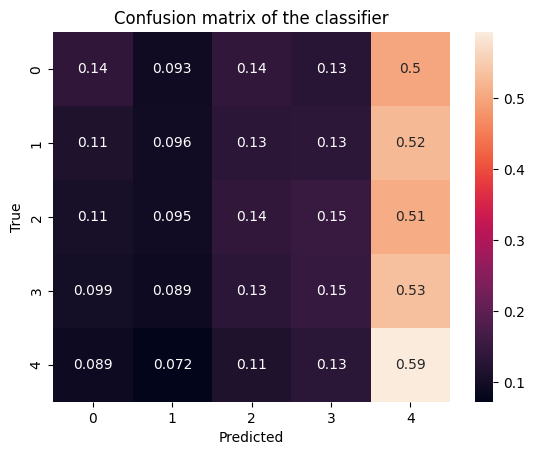

In [187]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [23]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)